<a href="https://colab.research.google.com/github/nadavschwalb/image_processing/blob/main/Lab6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Lab 6 - JPEG Compressionend </center></h1>

## Goal: Introduction of principles of the JPEG baseline coding system.

**Student IDs: 206180507 , 302208251**

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
%cd '/content/drive/My Drive/image_processing/Lab_6'
%ls
import os
path = os.getcwd() 
print('path: ' + path)

/content/drive/.shortcut-targets-by-id/1v9OpRtyz-wDF8ankyi5-Z5prTKKvv1il/image_processing/Lab_6
fresh_prince.png
path: /content/drive/.shortcut-targets-by-id/1v9OpRtyz-wDF8ankyi5-Z5prTKKvv1il/image_processing/Lab_6


Import the necessary libraries:

In [25]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_ubyte, color
import cv2
from skimage import restoration
import sys
import math
from PIL import Image
from scipy import fftpack

# 1. Helper Functions

In this section you will implement several helper functions which will be used in your implementation of JPEG compression and decompression. 

The functions ***quantize*** and ***dequantize*** are given:



In [26]:
def load_quantization_table(quality,block_size):
    q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])* quality   # JPEG normalizing array and zig-zag reordering
    if (block_size != 8):
        q = transform.resize(q, (block_size, block_size), preserve_range=True)
    return q

def quantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return np.array((block / q).round().astype(np.int32))

def dequantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return block * q

1.   Complete the funcion ***zigzag(M,N)*** written in the preliminary report:

In [9]:
def zigzag(M,N):
  ## Your code here ##
  zigzag_order = [[] for i in range(M+N-1)]
  for i in range(M):
    for j in range(N):
      diagonal_num = i+j
      if diagonal_num%2 == 0:
        zigzag_order[diagonal_num].append(i*N + j) # even row up
      else:
        zigzag_order[diagonal_num].insert(0,i*N + j) #odd row down
        
  result = []
  for diag in zigzag_order:
    for j in diag:
      result.append(j)
  return result

2.   Implement ***block_to_zigzag(block, order)***

This function transforms a *block_size* x *block_size* block of your image to a 1D array ordered according to the list of indices given in *order*. 

Hint: Use block.flatten()

3.   Implement ***zigzag_to_block(zigzag, order)***

This function performs the inverse operation. Given a 1D array ordered according to the list of indices given in *order*, it transforms it to a **square** block with its elements in their original location.


In [27]:
def block_to_zigzag(block,order):
    M = block.shape[0]
    zigzag_array = zigzag(M,M)
    zigzag_result = np.zeros((M**2,1))
    for k in range(len(zigzag_array)):
      i = zigzag_array[k] / M
      j = zigzag_array[k] % M
      i = i.astype(int)
      j = j.astype(int)
      zigzag_result[k] = block[i,j]
    return zigzag_result

    def find(order,index):
      for i in range(len(order)):
        if(order[i]==index):
          return i
      return -1


def zigzag_to_block(zigzag,order):
    rows = int(math.sqrt(len(zigzag)))
    order = order.astype(int)
    block = np.zeros((rows,rows), np.int32)
    for i in range(rows):
      for j in range(rows):
        index = i*rows + j
        for m in range(len(order)):
          if (order[m] == index):
            index = m
        block[i,j] = zigzag[m]
    return block

4. Implement 2D DCT and IDCT.

Expand your 1D function ***my_dct*** to 2D. Here you may use ***fftpack.dct*** and ***fftpack.idct***.

In [30]:
def dct_2d(image):
  image = fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')
  return image

def idct_2d(image):
  image = fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')
  image[image>127] = 127
  image[image<-128] = -128
  return image

# 2. JPEG Compression and Decompression

1.   Load and show the image of your choice (grayscale). Covert it to uint32.



Image shape: (300, 300), Image data type: uint32


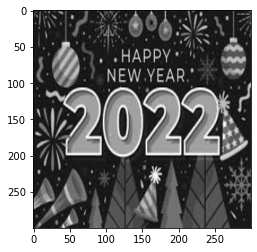

In [38]:
NewYear_img = plt.imread('new_year.bmp')

NewYear_img = cv2.cvtColor(NewYear_img,cv2.COLOR_RGB2GRAY)
NewYear_img = cv2.resize(NewYear_img, (300,300), interpolation=cv2.INTER_LINEAR)
NewYear_img = np.uint32(img_as_ubyte(NewYear_img))
print ("Image shape: {}, Image data type: {}".format(NewYear_img.shape,NewYear_img.dtype))
plt.imshow(NewYear_img, cmap = 'gray')
plt.show()

2.   Complete the missing code in the following ***im2jpeg*** implementation of JPEG compression and decompression.



In [39]:
# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on block_size x block_size DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size=8, quality=1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print("The input must be a UINT32 image.")
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # loop over image blocks
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
                # 1. extract a block of size block_size x block_size and center the data range on zero: [0, 255] --> [-128, 127]:
                block = (img[i:i+block_size, j:j+block_size] - 128).astype(np.int32)

                # 2. perform dct to the block:
                block_dct = dct_2d(block)

                # 3. quantize your dct block using given quality factor:
                block_dct_quantize = quantize(block_dct,quality,block_size)

                # 4. reorder in a zigzag pattern
                zigzag_pattern = block_to_zigzag(block_dct_quantize, order)

                # 5. omit trailing zeros in reordered block
                nonzero = np.flatnonzero(zigzag_pattern)
                if nonzero.size == 0:
                  nonzero = 0
                else:
                  nonzero = nonzero[-1]
                  zigzag_nonzero = np.zeros((nonzero+2,1),dtype=np.int32)
                  zigzag_nonzero[:nonzero+1] = zigzag_pattern[:nonzero+1]
                
                # 6. add eob in the end of the block
                zigzag_nonzero[:nonzero+1] = eob
                
                # 7. append the dct block to the list
                jpeg_list.append(zigzag_nonzero)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array



# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img,block_size,quality) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.

def jpeg2im(jpeg_img, block_size=8, quality = 1):
    eob = 256
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    
    # create new empty image: 
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        # 1. initialize new block
        zz_list = np.zeros(block_size*block_size)

        # 2. assign values from jpeg_img into beginning of zz_list
        zz_list[:end-start] = jpeg_img[start:end]

        # 3. convert zz_list back into block
        quant_matrix = zigzag_to_block(zz_list, order)

        # 4. dequnatize
        dct_matrix = dequantize(quant_matrix,quality,block_size)

        # 5. perform idct to block
        block = idct_2d(dct_matrix)

        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat
    

3. Compress your image using the JPEG compression algorithm calling ***im2jpeg*** and restore the image from its compressed form calling ***jpeg2im***.   
    * Present the original and restored images.
    * Print the number of elements in the original and compressed images. 
    * Explain why blocking effects can be seen in the restored image.   
    * Show the blocking effects by zooming in for intresting parts of the image. 

Write your answer here

# 3. Analysis

1. Plot the graph of compression ratio (Y axis) versus a “quality” parameter of *im2jpeg* (X axis). Use the supplied function *imratio*.  

Use the following quality parameters: 1,2,4,6,8,10,12,16,20,25

__Remark:__ the “quality” parameter defines the quality of compression and not the quality of restoration. It is defined to be greater or equal to 1. The “quality” equal to 1 corresponds to the best quality of restoration and the worst quality of compression.


In [ ]:
def imratio(original_img1,compressed_img2):
    return float(compressed_img2.nbytes)/original_img1.nbytes

Explain your results here

2. The Root Mean Square (RMS) error of restoration is defined in the following way:  
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

    where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images.    
    
    Plot the graph of Root Mean Square (RMS) Error of restoration (Y axis) versus compression ratio (X axis). This graph is called Rate-Distortion curve.  
    
__Hint__: you can use the supplied functions *imratio*.



Explain your results here

3.	Repeat question 2.3 for block sizes __4X4__ and __16X16__. 
    * Compare blocking effects for different block sizes.   
    * Compare the compression of the algorithm for different block sizes.   
    * What are the advantages and disadvantages of changing the block size? 

Insert your answers here

4. Use the following python build in function for JPEG compression:
        result = Image.fromarray((img).astype(np.uint8))
        result.save(Compressed_File_Name,"JPEG",optimize=True,quality= Your_quality)
   * Compress your image by using this function.
   * Load and show the compressed image. 
   * Compare the saved compressed image size in memory vs. the origonal image size.
   * Plot the compressed imag with quality of: 4, 10, 60.
   
   
__Note__: The 'quality' parameter is different here from the 'quality' parameter that we used in this lab implementation.


Insert your answer here